### Setup

In [ ]:
import json
import time
from functools import reduce

import pandas as pd
import numpy as np

from ast import literal_eval

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tqdm.autonotebook import tqdm

import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set(style='whitegrid')

import matplotlib.pyplot as plt

from py2neo import Graph, Node, Relationship

In [175]:
public_address = '54.174.175.98'
graph = Graph('bolt://{}:7687'.format(public_address), auth=('neo4j','myneo'))

def run_query(query, graph, print_query=False, run_query=True, 
              print_only=False, to_df=False, verbose=True):
    df = 1
    if print_only: 
        print_query = True
        run_query = False
    start_time = time.time()
    if print_query:
        print(query)
    if run_query:
        if to_df:
            df = graph.run(query).to_data_frame()
        else:
            graph.run(query)
    end_time = time.time()
    minutes_elapsed = (end_time-start_time)/60
    if verbose:
        print("Query completed in {:.2f} minutes.".format(minutes_elapsed))
    return df


### Write data to CSV

In [176]:
years_to_consider = range(1900, 2018)
max_years_to_predict = 10
years_tracked = 10

vars_to_use = ['adopters', 'timeScaledPageRank', 'citatons', 'node2vec']

max_year = max(years_to_consider)
min_year = min(years_to_consider)

metrics_pattern = 'MATCH (q)-[m{y}:METRICS_IN]->(:Year {{year:y.year+{y}}})'
metrics_string_list = [metrics_pattern.format(y=i) for i in range(years_tracked+1)]
metrics_string = '\n'.join(metrics_string_list)

var_pattern = 'coalesce(m{y}.{v},0) AS {v}_{y},'
var_string_list = [var_pattern.format(y=i,v=j) for i in range(years_tracked+1) for j in vars_to_use]
var_string = '\n'.join(var_string_list)

# predict_pattern = 'coalesce(mp.{v},0) AS predict_{v},'
# predict_string_list = [predict_pattern.format(v=j) for j in vars_to_use]
# predict_string = '\n'.join(predict_string_list)

where_pattern = 'exists(m{y}.node2vec)'
where_string_list = [where_pattern.format(y=i) for i in range(years_tracked+1)]
where_string = ' AND '.join(where_string_list)       

query = """
MATCH (q:Quanta)-[:PUBLISHED_IN]->(y:Year)
WHERE y.year>={miny} AND y.year<={maxy}-{ya}
{metrics_string}
//MATCH (q)-[mp:METRICS_IN]->(:Year {{year:y.year+{ya}}})
WHERE {where_string} //AND exists(mp.node2vec)
RETURN 
    {var_string}
    id(q) AS id, 
    y.year AS year
""".format(miny=min_year, 
           maxy=max_year,
           ya=max_years_to_predict,
           metrics_string=metrics_string,
           var_string=var_string, 
           where_string=where_string)

query_tocsv = """
CALL apoc.export.csv.query('
{q}
','/import/quanta.predict.{miny}.{maxy}.{yt}.csv', 
{{quotes:true}});
""".format(q=query, 
           miny=min_year, 
           maxy=max_year,
           yt=years_tracked)

run_query(query_tocsv, graph, to_df=False, print_only=True)


CALL apoc.export.csv.query('

MATCH (q:Quanta)-[:PUBLISHED_IN]->(y:Year)
WHERE y.year>=1900 AND y.year<=2017-10
MATCH (q)-[m0:METRICS_IN]->(:Year {year:y.year+0})
MATCH (q)-[m1:METRICS_IN]->(:Year {year:y.year+1})
MATCH (q)-[m2:METRICS_IN]->(:Year {year:y.year+2})
MATCH (q)-[m3:METRICS_IN]->(:Year {year:y.year+3})
MATCH (q)-[m4:METRICS_IN]->(:Year {year:y.year+4})
MATCH (q)-[m5:METRICS_IN]->(:Year {year:y.year+5})
MATCH (q)-[m6:METRICS_IN]->(:Year {year:y.year+6})
MATCH (q)-[m7:METRICS_IN]->(:Year {year:y.year+7})
MATCH (q)-[m8:METRICS_IN]->(:Year {year:y.year+8})
MATCH (q)-[m9:METRICS_IN]->(:Year {year:y.year+9})
MATCH (q)-[m10:METRICS_IN]->(:Year {year:y.year+10})
//MATCH (q)-[mp:METRICS_IN]->(:Year {year:y.year+10})
WHERE exists(m0.node2vec) AND exists(m1.node2vec) AND exists(m2.node2vec) AND exists(m3.node2vec) AND exists(m4.node2vec) AND exists(m5.node2vec) AND exists(m6.node2vec) AND exists(m7.node2vec) AND exists(m8.node2vec) AND exists(m9.node2vec) AND exists(m10.node2vec) //A

1

### Read in data for each year, format it, and write it back

In [39]:
fpath = '/tmp/data/quanta.predict.{miny}.{maxy}.{yt}.csv'.format(
    miny=min_year, maxy=max_year, yt=years_tracked, ya=years_ahead)
df = pd.read_csv(fpath, engine='python', error_bad_lines=False)
df = df.dropna()

for y in tqdm(range(years_tracked+1)):

    col = 'node2vec_{}'.format(y)    
    n2vdf = pd.DataFrame(df[col].apply(json.loads).tolist())
    n2v_dim = n2vdf.shape[1]
    n2vdf.columns = ['{}_{}'.format(col, i) for i in range(n2v_dim)]

    df = pd.concat([df.reset_index(drop=True), n2vdf.reset_index(drop=True)], axis=1)
    df = df.drop(col, axis=1)


df.to_csv('{}.out'.format(fpath))

NameError: name 'years_ahead' is not defined

### Read in prediction data and make predictions

In [302]:
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, PowerTransformer
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline

%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [178]:
df = pd.read_csv('/tmp/data/quanta.predict.{miny}.{maxy}.{yt}.csv.out'.format(
    miny=min_year, maxy=max_year, yt=years_tracked))

In [219]:
max_years_to_predict = 10
years_tracked = 5

results = pd.DataFrame(columns=['years_tracked', 'year_predicted', 'score'])

for years_to_track in tqdm(range(years_tracked)):
    for year_to_predict in range(years_to_track+1, max_years_to_predict+1):
        
        results = pd.DataFrame(columns=['years_tracked', 'year_predicted', 'score'])

        cols_to_keep = ['{v}_{y}'.format(y=i,v=j) 
                for i in range(years_to_track+1) 
                for j in [v for v in vars_to_use if v!='node2vec']]
        n2v_cols_to_keep =  ['node2vec_{y}_{i}'.format(y=y, i=i) 
                         for y in range(years_to_track+1)
                         for i in range(n2v_dim)]
        cols_to_keep = cols_to_keep + n2v_cols_to_keep
        X = df.loc[:, cols_to_keep]

        y_col = 'timeScaledPageRank_{y}'.format(y=year_to_predict)
        y = df.loc[:, y_col] > df[y_col].quantile(q=.95)


        param_grid = {"max_depth": [5, 10, None],
                      "max_features": [5, 10],
                      "n_estimators": [10, 100],
                      "bootstrap": [True, False]
                     }

        pipeline = make_pipeline(
            SMOTE(),
            QuantileTransformer(),
        #     MinMaxScaler(),
            GridSearchCV(RandomForestClassifier(),
                         param_grid=param_grid, 
                         refit=True, 
                         n_jobs=-1, 
                         cv=2, 
                         scoring='roc_auc') 
        )

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
        pipeline.fit(X_train, y_train)
        score = pipeline.score(X=X_test, y=y_test)

        results = results.append({'years_tracked': years_to_track, 
                                  'year_predicted': year_to_predict,
                                  'score': score}, 
                                 ignore_index=True)

TypeError: 'MinMaxScaler' object is not iterable

In [ ]:
years_to_track = 2
year_to_predict = 5

results = pd.DataFrame(columns=['years_tracked', 'year_predicted', 'score'])

cols_to_keep = ['{v}_{y}'.format(y=i,v=j) 
        for i in range(years_to_track+1) 
        for j in [v for v in vars_to_use if v!='node2vec']]
n2v_cols_to_keep =  ['node2vec_{y}_{i}'.format(y=y, i=i) 
                 for y in range(years_to_track+1)
                 for i in range(n2v_dim)]
cols_to_keep = cols_to_keep + n2v_cols_to_keep
X = df.loc[:, cols_to_keep]

y_col = 'timeScaledPageRank_{y}'.format(y=year_to_predict)
y = df.loc[:, y_col] > df[y_col].quantile(q=.95)


param_grid = {"max_depth": [5, 10, None],
              "max_features": [5, 10],
              "n_estimators": [10, 100],
              "bootstrap": [True, False]
             }

pipeline = make_pipeline(
    SMOTE(),
    QuantileTransformer(),
#     MinMaxScaler(),
    GridSearchCV(RandomForestClassifier(),
                 param_grid=param_grid, 
                 refit=True, 
                 n_jobs=-1, 
                 cv=2, 
                 scoring='roc_auc') 
)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipeline.fit(X_train, y_train)
score = pipeline.score(X=X_test, y=y_test)

results = results.append({'years_tracked': years_to_track, 
                          'year_predicted': year_to_predict,
                          'score': score}, 
                         ignore_index=True)

In [ ]:
results

In [ ]:
!pip install plot-metric colorlover
from plot_metric.functions import  BinaryClassification

y_pred = pipeline.predict_proba(X_test)[:,1]
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
plt.subplot2grid((2,6), (0,4), colspan=2)
bc.plot_class_distribution()
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)
plt.show()
bc.print_report()

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
600064    False
600065    False
600066    False
600067    False
600068    False
600069    False
600070    False
600071    False
600072    False
600073    False
600074    False
600075    False
600076    False
600077    False
600078    False
600079    False
600080    False
600081    False
600082     True
600083    False
600084    False
600085    False
600086    False
600087    False
600088    False
600089    False
600090    False
600091    False
600092    False
600093    False
Name: timeScaledPageRank

In [306]:
y_pred = pipeline.predict(X_test)
f1_score(y_pred=y_pred, y_true=y_test)

0.5624238485906913

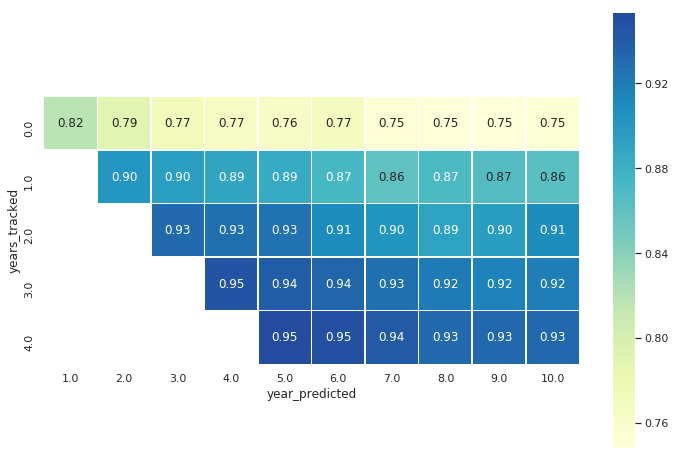

In [82]:
sns.heatmap(data=results.pivot('years_tracked', 'year_predicted', 'score'), 
           annot=True, fmt='.2f', linewidth=.5, cbar=True, square=True, 
           cmap='YlGnBu', center=results['score'].mean())

In [ ]:
plt.figure(figsize=(10,20))
feature_importance = pd.DataFrame.from_dict(
    dict(zip(X.columns,pipeline.steps[1][1].feature_importances_)), orient='index').T
sns.barplot(orient='h',data=feature_importance)

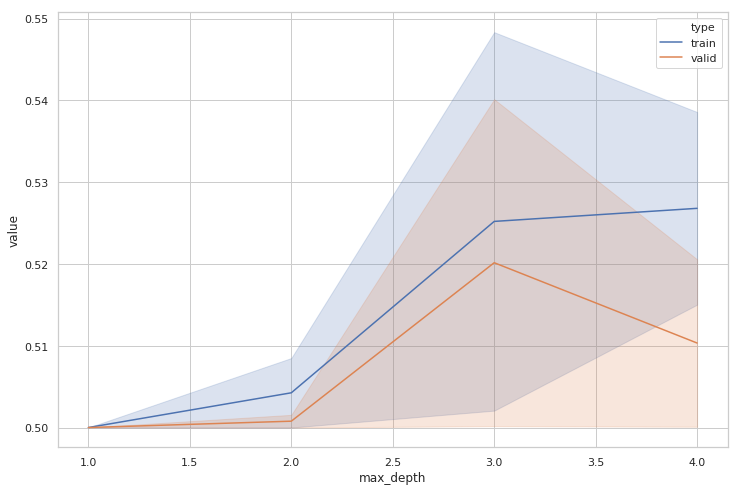

In [272]:
from sklearn.model_selection import validation_curve

param = 'max_depth'
param_range = list(range(1,5,1))
n_cv = 2

train_scores, valid_scores = validation_curve(RandomForestClassifier(),
                                             X, y,
                                             n_jobs=1,
                                             param_name=param,
                                             scoring='balanced_accuracy',
                                             param_range=param_range,
                                             cv=n_cv)

vdf = pd.DataFrame(np.concatenate([train_scores, valid_scores]),
             columns=['cv_fold_{}'.format(i) for i in range(n_cv)],
            )
vdf[param] = param_range*2
vdf['type'] = ['train']*len(param_range) + ['valid']*len(param_range)

sns.lineplot(data=vdf.melt(id_vars=['type', param]), 
             x=param, y='value', hue='type')

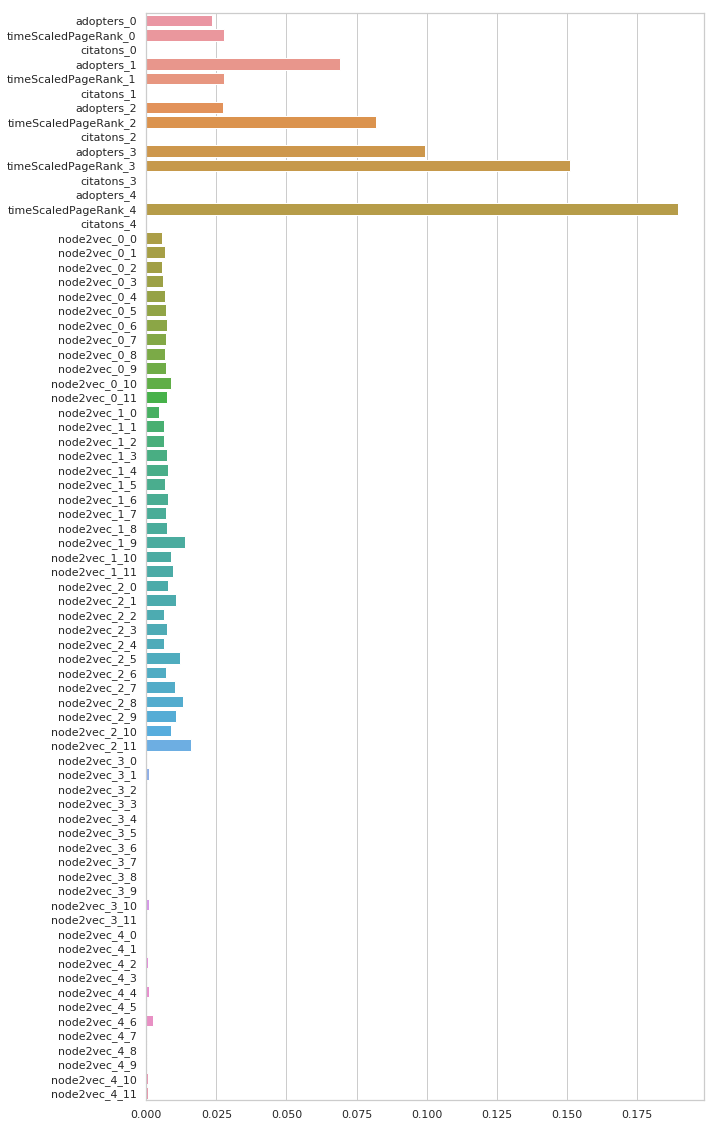

In [ ]:
idf = df[]


from sklearn.model_selection import train_test_split

df.dropna(inplace=True)
columns_to_keep = df.columns.drop('high_impact').drop('id') \
    .drop('timeScaledPageRank_predict').drop('citations_predict').drop('year')

X = df.loc[:, columns_to_keep]
y = df.loc[:,'high_impact']



In [188]:


count_class_0, count_class_1 = df[y_col].value_counts()
df_class_0 = df[df[y_col] == 0]
df_class_1 = df[df[y_col] == 1]

# over-sample
if count_class_1 > count_class_0:
    df_class_1_under = df_class_1.sample(count_class_0)
    df_class_0_over = df_class_0.sample(n=count_class_1, replace=True)
#     df = pd.concat([df_class_1_under, df_class_0], axis=0)
    df = pd.concat([df_class_1, df_class_0_over], axis=0)
else:
    df_class_0_under = df_class_0.sample(count_class_1)
    df_class_1_over = df_class_1.sample(n=count_class_0, replace=True)
#     df = pd.concat([df_class_1, df_class_0_under], axis=0)
    df = pd.concat([df_class_1_over, df_class_0], axis=0)
        
print(df[y_col].value_counts())

ValueError: too many values to unpack (expected 2)

In [ ]:
# cols_to_plot=['citations_0', 'citations_1', 'citations_5' 
#               'adopters_0', 'adopters_1', 
#               'timeScaledPageRank_0', 'timeScaledPageRank_1', 'timeScaledPageRank_5'
#                  ]

# g = sns.pairplot(df,
#                  y_vars=cols_to_plot, 
#                  x_vars=cols_to_plot,
#                  hue='high_impact', 
#                  plot_kws=dict(s=35, alpha=0.1))

### Predictions

In [ ]:
from sklearn.model_selection import train_test_split

df.dropna(inplace=True)
columns_to_keep = df.columns.drop('high_impact').drop('id') \
    .drop('timeScaledPageRank_predict').drop('citations_predict').drop('year')

X = df.loc[:, columns_to_keep]
y = df.loc[:,'high_impact']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75)

test_inds = X_test.index



In [235]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

clf = DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)

export_graphviz(clf, out_file='/tmp/data/dotfile.dot', filled=True, rounded=True, special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeClassifier


param = 'max_depth'
param_range = list(range(1,5,1))
n_cv = 5

train_scores, valid_scores = validation_curve(DecisionTreeClassifier(),
                                             X, y,
                                             n_jobs=1,
                                             param_name=param,
                                             scoring='roc_auc',
                                             param_range=param_range,
                                             cv=n_cv)

vdf = pd.DataFrame(np.concatenate([train_scores, valid_scores]),
             columns=['cv_fold_{}'.format(i) for i in range(n_cv)],
            )
vdf[param] = param_range*2
vdf['type'] = ['train']*len(param_range) + ['valid']*len(param_range)

sns.lineplot(data=vdf.melt(id_vars=['type', param]), 
             x=param, y='value', hue='type')

In [ ]:
vdf = pd.DataFrame(np.concatenate([train_scores, valid_scores]),
             columns=['cv_fold_{}'.format(i) for i in range(n_cv)],
            )
vdf[param] = param_range*2
vdf['type'] = ['train']*len(param_range) + ['valid']*len(param_range)

sns.lineplot(data=vdf.melt(id_vars=['type', param]), 
             x=param, y='value', hue='type')

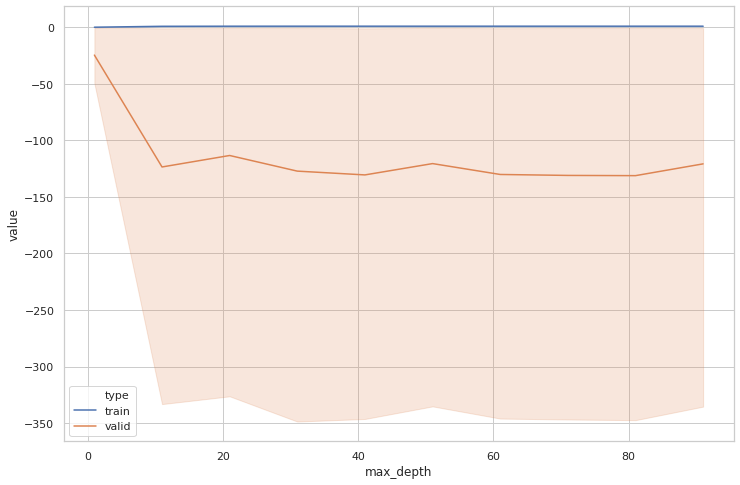

In [191]:
sum(df['timeScaledPageRank_1']>cutoff) / sum(df['timeScaledPageRank_predict']>cutoff)

0.5547594412829798

1.3215441902612113


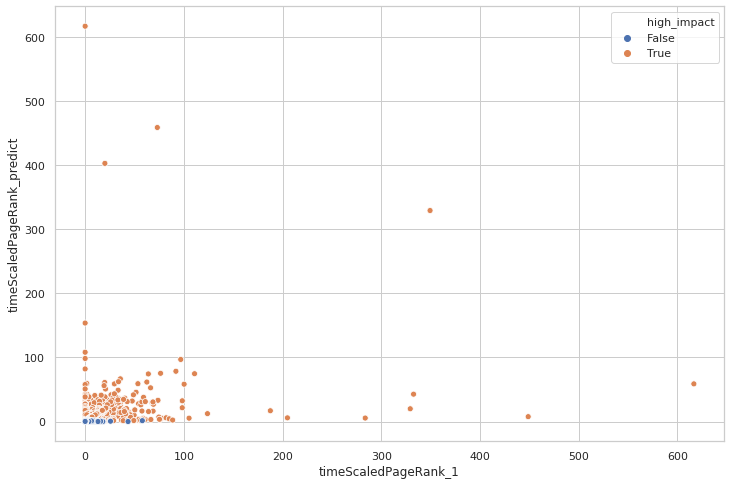

In [199]:
print(cutoff)
sns.scatterplot(data=df, x='timeScaledPageRank_1', y='timeScaledPageRank_predict', hue='high_impact')

In [86]:
y_pred = clf.predict(X_test)



from sklearn.metrics import f1_score, classification_report
print("F1 Score: {}".format(f1_score(y_true=y_test, y_pred=y_pred)))

print(classification_report(y_true=y_test, y_pred=y_pred))

F1 Score: 0.8567451930511882
             precision    recall  f1-score   support

      False       0.86      0.85      0.86      9660
       True       0.85      0.86      0.86      9670

avg / total       0.86      0.86      0.86     19330



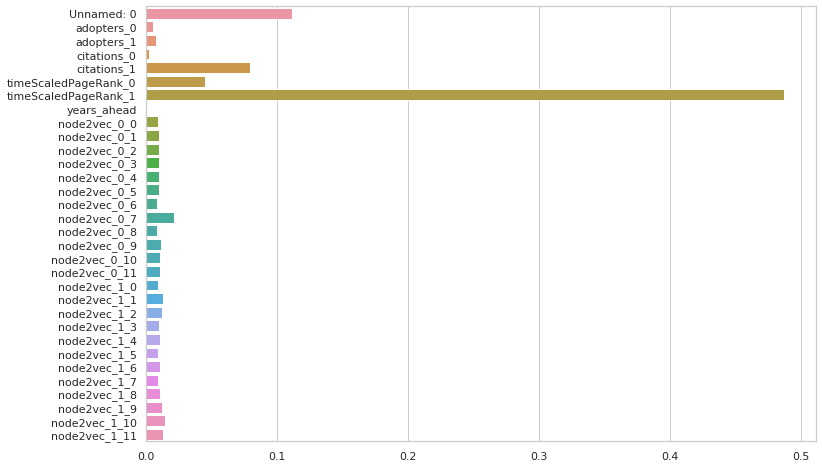

In [61]:
feature_importance = pd.DataFrame.from_dict(
    dict(zip(X.columns, clf.feature_importances_)), orient='index').T
sns.barplot(orient='h',data=feature_importance)

Text(84.5, 0.5, 'True')

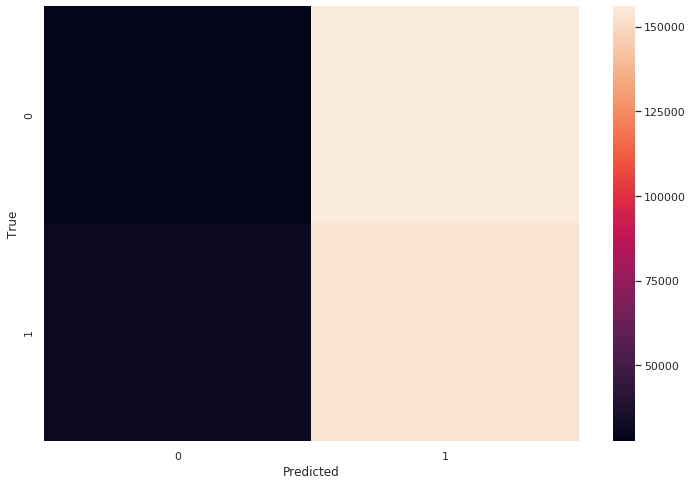

In [63]:
from sklearn.metrics import confusion_matrix


conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
ax = sns.heatmap(conf_mat)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)

# df.drop(columns='lr_predicted')
df.loc[test_inds, 'lr_predicted'] = y_pred
df.loc[test_inds, 'lr_accuracy'] = (results['high_impact'] == results['dt_predicted']).astype(int)

print("Clasificationa accuracy: {}".format(clf.score(X_test, y_test)))
print("F1 Score: {}".format(f1_score(y_true=y_test, y_pred=y_pred)))

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
ax = sns.heatmap(conf_mat)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

feature_importance = pd.DataFrame.from_dict(
    dict(zip(X.columns, clf.feature_importances_)), orient='index').T
sns.barplot(orient='h',data=feature_importance)

In [35]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)
if 'dt_predicted' in df.columns:
    df.drop(columns='dt_predicted')
df.loc[test_inds, 'dt_predicted'] = y_pred
df.loc[test_inds, 'dt_correct'] = (results['high_impact'] == results['dt_predicted']).astype(int)

print("Clasificationa accuracy: {}".format(clf.score(X_test, y_test)))
print("F1 Score: {}".format(f1_score(y_true=y_test, y_pred=y_pred)))

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
ax = sns.heatmap(conf_mat)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

feature_importance = pd.DataFrame.from_dict(
    dict(zip(X.columns, clf.feature_importances_)), orient='index').T
sns.barplot(orient='h',data=feature_importance)

ValueError: Must have equal len keys and value when setting with an iterable

ValueError: Must have equal len keys and value when setting with an iterable

In [546]:
sns.lineplot(x='year', y='decision_treeclassification_accuracy',
             data=df.loc[test_inds,:], 
             dashes=False, markers=True)

KeyError: 'dt_predicted'

In [243]:
!pip install tpot --user

     |████████████████████████████████| 81kB 35.9MB/s eta 0:00:01
     |████████████████████████████████| 20.4MB 47.8MB/s eta 0:00:01
     |████████████████████████████████| 153kB 56.5MB/s eta 0:00:01
     |████████████████████████████████| 286kB 54.1MB/s eta 0:00:01
Failed to build stopit
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Running setup.py install for stopit ... done
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, n_jobs=-1, 
                                                    scoring='r2', config_dict='TPOT light', 
                                                    max_time_mins=30, max_eval_time_mins=5) 
tpot.fit(X_train, y_train)



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: DecisionTreeRegressor(MinMaxScaler(input_matrix), max_depth=9, min_samples_leaf=19, min_samples_split=6)


TPOTRegressor(config_dict='TPOT light', crossover_rate=0.1, cv=5,
       disable_update_check=False, early_stop=None, generations=1000000,
       max_eval_time_mins=5, max_time_mins=30, memory=None,
       mutation_rate=0.9, n_jobs=-1, offspring_size=None,
       periodic_checkpoint_folder=None, population_size=20,
       random_state=None, scoring='r2', subsample=1.0, template=None,
       use_dask=False, verbosity=2, warm_start=False)

In [13]:
tpot.score(X_test, y_test)

0.32070619981531434

In [14]:
tpot.export('tpot_exported_pipeline.py')

In [1]:
!cat tpot_exported_pipeline.py

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:0.24912375544428125
exported_pipeline = make_pipeline(
    MinMaxScaler(),
    DecisionTreeRegressor(max_depth=9, min_samples_leaf=19, min_samples_split=6)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [6]:
years_ahead = 4
df = pd.read_csv('/tmp/data/quanta.predict.{miny}.{maxy}.{ya}.csv.out'.format(
        miny=min_year, maxy=max_year, ya=years_ahead))
df.shape

(773198, 36)

In [4]:
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

/home/jovyan/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running